In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0


In [2]:
!pip3 uninstall -y keras
!pip uninstall -y keras-nightly

Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0


In [3]:
!pip3 install keras==2.2.4

     |████████████████████████████████| 312 kB 31.4 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 


In [4]:
!pip3 install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.1 MB 7.9 kB/s 
     |████████████████████████████████| 488 kB 37.8 MB/s 
     |████████████████████████████████| 3.1 MB 37.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0


In [5]:
!pip3 install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 30.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [6]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """

    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """

    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """

    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
            initializer=self.kernel_initializer,
            name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
                # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding, name):
    """
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv1D(filters=dim_vector * n_channels, kernel_size=kernel_size, strides=strides, padding=padding, name=name)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [7]:
import numpy as np
import pandas as pd
import string

In [8]:

rng_seed=42

In [9]:

# Seed the numpy RNG to get reproducible results
np.random.seed(rng_seed)

In [10]:
!pip install biopython

     |████████████████████████████████| 2.3 MB 28.4 MB/s 


In [11]:
from Bio import SeqIO

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [13]:

import keras.backend as K
from keras.models import Model, Sequential
from keras import layers
from keras.layers import Input, Flatten, Reshape, Maximum, BatchNormalization, Dropout, Concatenate, Activation, Lambda
from keras.layers import Embedding, Dense, GlobalMaxPooling1D
from keras.layers import SimpleRNN, RNN, SimpleRNNCell, GRUCell, LSTMCell, LSTM, GRU, CuDNNGRU, CuDNNLSTM,Conv1D, Bidirectional
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import callbacks
from keras.models import load_model

from keras.layers import LeakyReLU, Bidirectional, Flatten, SpatialDropout1D
# from keras.datasets import imdb
from keras.preprocessing import sequence
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skmetrics
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [15]:
%%time
df_PPI_yeast_dataset = pd.read_csv("/content/drive/MyDrive/Supplementary S1.csv")

CPU times: user 149 ms, sys: 23 ms, total: 172 ms
Wall time: 656 ms


In [16]:
%%time
uniprot_db = SeqIO.to_dict(SeqIO.parse("/content/drive/MyDrive/uniprot_sprot.fasta", "fasta"))

CPU times: user 10.8 s, sys: 911 ms, total: 11.7 s
Wall time: 12.7 s


In [17]:
%%time
uniprot_db_dict = {}
for key in uniprot_db.keys():
    # Since we only want to search by the code, change the dictionary keys to match our format
    # Get the substring between the two | |
    new_key = key[key.find('|')+1:key.rfind('|')]
    # Also, we just want the sequence, so save it alone (instead of the full record)
    uniprot_db_dict[new_key] = str(uniprot_db[key].seq)

CPU times: user 1.34 s, sys: 202 ms, total: 1.55 s
Wall time: 1.55 s


In [18]:
df_PPI_yeast_dataset

,proteinA,proteinB,interaction
0,P09798,P09798,1
1,P38717,P06782,1
2,P07342,P25605,1
3,P15790,P38930,1
4,P22035,P07269,1
...,...,...,...
65846,P53184,P22855,0
65847,P53184,P36062,0
65848,P53184,Q08236,0
65849,P53184,Q12331,0


In [19]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset

In [20]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinA_seq = [uniprot_db_dict[prot_id] for prot_id in df_PPI_yeast_dataset_processed['proteinA'].values])

In [21]:
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinB_seq = [uniprot_db_dict[prot_id] for prot_id in df_PPI_yeast_dataset_processed['proteinB'].values])

In [22]:

n_gram_len = 3
ngram_overlap = 3

In [23]:
def generate_ngram_list(input_seq, n, overlap_step):
    n=1 if n<1 else n
    overlap_step=1 if overlap_step<1 else overlap_step
    # Reverse input
    input_seq = input_seq[::-1]
    output = [input_seq[ii:ii+n] for ii in np.arange(0, len(input_seq), overlap_step)]
    while(len(output[-1]) != n):
        output.pop()
    # Reverse output
    output[:] = output[::-1]
    return output

In [24]:
def generate_ngram_seq(input_seq, n, overlap_step):
    ngram_list = generate_ngram_list(input_seq, n, overlap_step)
    # Reverse each sequences as well
    output = (''.join([' %s' % (ngram[::-1]) for ngram in ngram_list]))
    return output

In [25]:
def generate_ngram_dictionary(n, source_dict):
    unique_symbols = len(source_dict)
    unique_ngrams = unique_symbols**n
    ngram_matrix=np.empty((unique_ngrams,n), dtype='U1')
    
    for ii in np.arange(n):
        change_freq = unique_symbols**(n-ii-1)
        symbol_idx = 0
        for jj in np.arange(0, unique_ngrams, change_freq):
            ngram_matrix[jj:(jj+change_freq), ii] = source_dict[symbol_idx]
            symbol_idx+=1
            if(symbol_idx == unique_symbols):
                symbol_idx=0
            
    # Reduce the second axis
    ngram_list = [ ''.join(symbol) for symbol in [l for l in ngram_matrix]]
    return ngram_list

In [26]:

%%time
aminoacid_dictionary = []
for seq in df_PPI_yeast_dataset_processed.proteinA_seq.values:
    for symbol in list(seq):
        if(not symbol in aminoacid_dictionary):
            aminoacid_dictionary.append(symbol)

CPU times: user 10.2 s, sys: 16.3 ms, total: 10.2 s
Wall time: 10.2 s


In [27]:
print(len(aminoacid_dictionary), aminoacid_dictionary)

20 ['M', 'K', 'F', 'C', 'L', 'Y', 'H', 'I', 'V', 'G', 'A', 'T', 'S', 'N', 'R', 'P', 'E', 'Q', 'D', 'W']


In [28]:

%%time
ngram_dict = generate_ngram_dictionary(n_gram_len, aminoacid_dictionary)
print(ngram_dict[:10])

['MMM', 'MMK', 'MMF', 'MMC', 'MML', 'MMY', 'MMH', 'MMI', 'MMV', 'MMG']
CPU times: user 27.6 ms, sys: 112 µs, total: 27.7 ms
Wall time: 29.7 ms


In [29]:
%%time
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinA_ngramseq = [generate_ngram_seq(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinA_seq'].values])
df_PPI_yeast_dataset_processed = df_PPI_yeast_dataset_processed.assign(proteinB_ngramseq = [generate_ngram_seq(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinB_seq'].values])

CPU times: user 24.6 s, sys: 1.3 s, total: 25.9 s
Wall time: 23.9 s


In [30]:
%%time
# Get all unique trigrams
ngram_dictionary_A = np.unique([generate_ngram_list(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinA_seq'].values])[0]
ngram_dictionary_B = np.unique([generate_ngram_list(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df_PPI_yeast_dataset_processed['proteinB_seq'].values])[0]
ngram_dictionary = np.unique(np.concatenate([ngram_dictionary_A, ngram_dictionary_B]))
ngram_dictionary

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 25.2 s, sys: 2.26 s, total: 27.4 s
Wall time: 25.5 s


In [31]:

df_PPI_yeast_dataset_processed

,proteinA,proteinB,interaction,proteinA_seq,proteinB_seq,proteinA_ngramseq,proteinB_ngramseq
0,P09798,P09798,1,MKFCLYCCHCYIVICGKATHYYKSSKATSNLKSSNRVLMRNPMSPS...,MKFCLYCCHCYIVICGKATHYYKSSKATSNLKSSNRVLMRNPMSPS...,MKF CLY CCH CYI VIC GKA THY YKS SKA TSN LKS S...,MKF CLY CCH CYI VIC GKA THY YKS SKA TSN LKS S...
1,P38717,P06782,1,MSVHGRDPKKRQLRLISVAFKEASIDSPSFRASVNFFQTRVDALED...,MSSNNNTNTAPANANSSHHHHHHHHHHHHHGHGGSNSTLNNPKSSL...,VHG RDP KKR QLR LIS VAF KEA SID SPS FRA SVN F...,MSS NNN TNT APA NAN SSH HHH HHH HHH HHH GHG G...
2,P07342,P25605,1,MIRQSTLKNFAIKRCFQHIAYRNTPAMRSVALAQRFYSSSSRYYSA...,MLRSLLQSGHRRVVASSCATMVRCSSSSTSALAYKQMHRHATRPPL...,MIR QST LKN FAI KRC FQH IAY RNT PAM RSV ALA Q...,MLR SLL QSG HRR VVA SSC ATM VRC SSS STS ALA Y...
3,P15790,P38930,1,MKCRVWSEARVYTNINKQRTEEYWDYENTVIDWSTNTKDYEIENKV...,MGSRSENVGTVTREGSRVEQDDVLMDDDSDSSEYVDMWIDLFLGRK...,MKC RVW SEA RVY TNI NKQ RTE EYW DYE NTV IDW S...,MGS RSE NVG TVT REG SRV EQD DVL MDD DSD SSE Y...
4,P22035,P07269,1,MSNISTKDIRKSKPKRGSGFDLLEVTESLGYQTHRKNGRNSWSKDD...,MMEEFSYDHDFNTHFATDLDYLQHDQQQQQQQQHDQQHNQQQQPQP...,SNI STK DIR KSK PKR GSG FDL LEV TES LGY QTH R...,MEE FSY DHD FNT HFA TDL DYL QHD QQQ QQQ QQH D...
...,...,...,...,...,...,...,...
65846,P53184,P22855,0,MKTLIVVDMQNDFISPLGSLTVPKGEELINPISDLMQDADRDWHRI...,MSSEDIIYDPQFKPVQGIYENRLRQFIDTGGDYHDLNLPKFYDKKR...,MKT LIV VDM QND FIS PLG SLT VPK GEE LIN PIS D...,MSS EDI IYD PQF KPV QGI YEN RLR QFI DTG GDY H...
65847,P53184,P36062,0,MKTLIVVDMQNDFISPLGSLTVPKGEELINPISDLMQDADRDWHRI...,MNGKEVSSGSGRTQSNNNKKNNNGGSTGISHASGSPLTDGNGGNSN...,MKT LIV VDM QND FIS PLG SLT VPK GEE LIN PIS D...,GKE VSS GSG RTQ SNN NKK NNN GGS TGI SHA SGS P...
65848,P53184,Q08236,0,MKTLIVVDMQNDFISPLGSLTVPKGEELINPISDLMQDADRDWHRI...,MDTVTVLNELRAQFLRVCPEKDQMKRIIKPYIPVDEFNTEQCLDSS...,MKT LIV VDM QND FIS PLG SLT VPK GEE LIN PIS D...,MDT VTV LNE LRA QFL RVC PEK DQM KRI IKP YIP V...
65849,P53184,Q12331,0,MKTLIVVDMQNDFISPLGSLTVPKGEELINPISDLMQDADRDWHRI...,MIFNLPVSVLLYFSLIWAMEPSFVRGKNVVNLITFKDSNGKLHKRL...,MKT LIV VDM QND FIS PLG SLT VPK GEE LIN PIS D...,FNL PVS VLL YFS LIW AME PSF VRG KNV VNL ITF K...


In [32]:
lA = np.array([int(3*len(p)/4) for p in df_PPI_yeast_dataset_processed.proteinA_ngramseq.values])
lB = np.array([int(3*len(p)/4) for p in df_PPI_yeast_dataset_processed.proteinB_ngramseq.values])

In [69]:
len(lA)

65851

In [33]:
np.histogram(np.concatenate([lA,lB]), bins=[0,50,100,200,300,500,800,1000,1500,2000,3000,4000,5000])

(array([    0,  2697, 15153, 20700, 37957, 30059, 11034, 10589,  2348,
         1038,   111,    16]),
 array([   0,   50,  100,  200,  300,  500,  800, 1000, 1500, 2000, 3000,
        4000, 5000]))

In [70]:
np.histogram(np.concatenate([lA,lB]), bins=15)

(array([53404, 45888, 18841,  8728,  2697,   979,   713,   295,    30,
           89,     0,    22,     7,     0,     9]),
 array([  51. ,  374.8,  698.6, 1022.4, 1346.2, 1670. , 1993.8, 2317.6,
        2641.4, 2965.2, 3289. , 3612.8, 3936.6, 4260.4, 4584.2, 4908. ]))

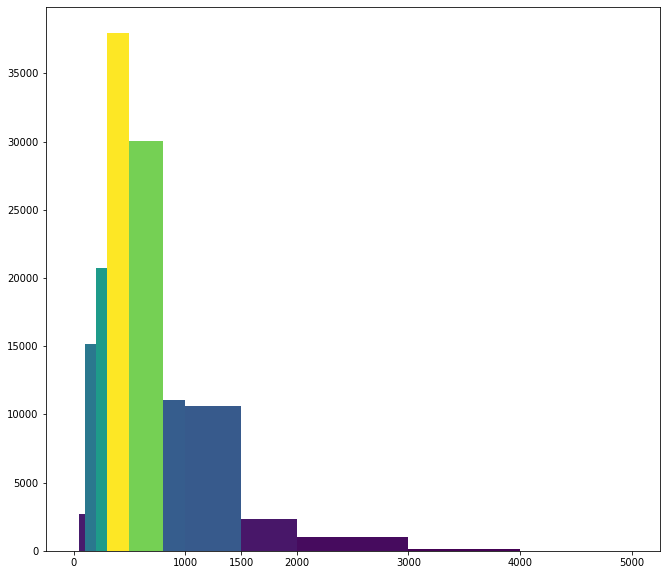

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(figsize=(11,10))

# We can set the number of bins with the `bins` kwarg
N, bins, patches = axs.hist(np.concatenate([lA,lB]), bins=[0,50,100,200,300,500,800,1000,1500,2000,3000,4000,5000])
axs.set_xticks([0,1000,1500,2000,3000,4000,5000])

fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = matplotlib.colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

In [34]:

maxlength=1000

In [35]:
source_xA = df_PPI_yeast_dataset_processed.proteinA_ngramseq
source_xB = df_PPI_yeast_dataset_processed.proteinB_ngramseq
num_words_dict = len(ngram_dict)

In [36]:
%%time
train_tk = Tokenizer(num_words=num_words_dict, char_level=False)
# Fit to all the sequences (both from proteinA and proteinB)
train_tk.fit_on_texts(np.concatenate([source_xA.values, source_xB.values], axis=0))

CPU times: user 16.5 s, sys: 1.89 ms, total: 16.5 s
Wall time: 16.6 s


In [37]:

np.arange(1,6)

array([1, 2, 3, 4, 5])

In [38]:
pad_sequences([np.arange(1,6)],maxlen=10, padding='pre', truncating='pre')

array([[0, 0, 0, 0, 0, 1, 2, 3, 4, 5]], dtype=int32)

In [39]:

np.arange(1,16)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [40]:
pad_sequences([np.arange(1,16)],maxlen=10, padding='pre', truncating='pre')

array([[ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]], dtype=int32)

In [41]:
def preprocess_data(data_A, data_B, tokenizer, maxlen = maxlength):
    # Tokenize the input
    # Get the sequences of codes (numbers representing a letter)
    seq_A = tokenizer.texts_to_sequences(data_A)
    seq_B = tokenizer.texts_to_sequences(data_B)
    # Pad the sequences to the max length
    padded_seq_A = pad_sequences(seq_A, maxlen=maxlen, padding='pre', truncating='pre')
    padded_seq_B = pad_sequences(seq_B, maxlen=maxlen, padding='pre', truncating='pre')
    
    return padded_seq_A, padded_seq_B

In [42]:

%%time
# Use the function to preprocess the data from the data source of choice
valid_xA, valid_xB = preprocess_data(source_xA.values, source_xB.values, train_tk, maxlength)
valid_label = df_PPI_yeast_dataset_processed.interaction.values

CPU times: user 16.1 s, sys: 490 ms, total: 16.6 s
Wall time: 16.5 s


In [43]:

# Parameters
nb_epochs = 5
b_size = 128
init_lr = 0.001
val_split = 0.1


embedding_output_dim = 512
drop_rate = 0.2
weight_decay = wd = 0.0001
do_order_decorrelation = False

In [44]:
def fc_block(input_tensor, features,name, activation_f='relu', wd=0.0001):
    x = Conv1D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1'+name)(input_tensor)
    # x = SpatialDropout1D(rate_drop_dense)(x)
    x = Dropout(0.5)(x)
    primary_caps = PrimaryCap(x, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name="primary_caps"+name)
    
    return primary_caps

In [45]:
def recurrent_block(input_tensor, recurrent_layer, features, return_sequences=False, wd=0.0001):
    output = input_tensor
    output =LSTM(units=features, 
                        #kernel_regularizer=regularizers.l2(wd), 
                        #recurrent_regularizer=regularizers.l2(wd), 
                        #activity_regularizer=regularizers.l2(wd), 
                        return_sequences=return_sequences)(output)
    output = BatchNormalization(axis=1)(output)
    
    return output

In [46]:
def sequence_feat_extractor(input_tensor, recurrent_layer, return_sequences=False, wd=0.0001):
    output = input_tensor
    output = recurrent_block(output, recurrent_layer, 64, return_sequences=return_sequences)
    return output

In [47]:
def branch_extractor(input_tensor, dropout_rate=0.5):
    output = input_tensor
    output = sequence_feat_extractor(output, LSTM, return_sequences=True)
    # output = fc_block(output, 64, activation_f='elu')
    output = Dropout(dropout_rate)(output)
    return output

In [48]:
def NN(input_dict_nwords):
    input_A = Input(batch_shape=(None, maxlength))
    input_B = Input(batch_shape=(None, maxlength))
    
    shared_embedding = Embedding(input_dim = input_dict_nwords, 
                         output_dim = embedding_output_dim, 
                         input_length=maxlength
                         , embeddings_regularizer=regularizers.l2(wd)
                        )
    # Process branch A
    output_A = input_A
    output_A = shared_embedding(output_A)
    output_A = BatchNormalization(axis=1)(output_A)
    output_A = branch_extractor(output_A)

    output_A = fc_block(output_A, 512, activation_f='relu', name="A")
    
    # Process branch B
    output_B = input_B
    output_B = shared_embedding(output_B)
    output_B = BatchNormalization(axis=1)(output_B)
    output_B = branch_extractor(output_B)

    output_B = fc_block(output_B, 512, activation_f='relu', name="B")
    
    # Merge branches
    output = Concatenate(axis=1)([output_A, output_B])
    # Process merged branch
    
    
    # Output layer (binary)
    # output = Dense(units=2
    #                , activation='softmax'
    #                , use_bias=True
    #                , kernel_initializer='he_normal'
    #                , kernel_regularizer=regularizers.l2(wd)
    #                , bias_regularizer=regularizers.l2(wd)
    #               )(output)

    category_caps = CapsuleLayer(num_capsule=2, dim_vector=16, num_routing=3, name='category_caps')(output)
    out_caps = Length(name='out_caps')(category_caps)
    
    model = Model([input_A, input_B], outputs=out_caps)
    
    return model


In [49]:

NN(num_words_dict).summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 512)    4096000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________

In [44]:
def decorrelate_order(input_A, input_B, input_labels, random_seed = None):
    out_A = input_A
    out_B = input_B
    out_labels = input_labels
    # Shuffle the data horizontally (swap some protein pairs to decorrelate the positioning)
    # This will be done by shuffling the data vertically, then exchanging the second half of each vector
    # Shuffle the data
    indices_shuffled = np.random.permutation(out_labels.shape[0])
    out_A = out_A[indices_shuffled]
    out_B = out_B[indices_shuffled]
    out_labels = out_labels[indices_shuffled]

    # Exchange the second half of the samples
    # Labels stay unchanged
    tmp_A = out_A.copy()
    half_index = int(out_A.shape[0]/2)
    out_A = np.concatenate([out_A[:half_index], out_B[half_index:]], axis=0)
    out_B = np.concatenate([out_B[:half_index], tmp_A[half_index:]], axis=0)
    del tmp_A
    
    # Shuffle the data again
    indices_shuffled = np.random.permutation(out_labels.shape[0])
    out_A = out_A[indices_shuffled]
    out_B = out_B[indices_shuffled]
    out_labels = out_labels[indices_shuffled]
    
    return out_A, out_B, out_labels

In [45]:
def generate_dset(input_A, input_B, input_labels, decorrelate=True, random_seed = None):
    
    positive_mask = (valid_label > 0)
    negative_mask = ~positive_mask
    
    positive_indices = np.array(np.nonzero(positive_mask)[0])
    last_positive = np.amax(positive_indices)

    n_positives = last_positive+1
    '''
    # Get the negative indices from the mask
    negative_indices = np.array(np.nonzero(negative_mask)[0])
    # Shuffle them using the random seed
    negative_indices = np.random.RandomState(seed=random_seed).permutation(negative_indices)

    # Keep the first to match the positive indices
    negative_indices = negative_indices[:n_positives]
    '''
    # Shuffle the negative indices and keep the first n_positives to replicate their selection
    negative_indices = np.array(np.nonzero(negative_mask)[0])
    negative_indices = negative_indices[np.random.RandomState(seed=random_seed).permutation(negative_indices.shape[0])]
    negative_indices = negative_indices[:n_positives]
    
    # Now, keep all the positives and the negatives indicated by negative_indices
    dset_xA = np.concatenate([input_A[positive_indices], input_A[negative_indices]], axis=0)
    dset_xB = np.concatenate([input_B[positive_indices], input_B[negative_indices]], axis=0)
    dset_labels = np.concatenate([input_labels[positive_indices], input_labels[negative_indices]], axis=0)
    
    if(decorrelate):
        dset_xA, dset_xB, dset_labels = decorrelate_order(dset_xA, dset_xB, dset_labels)
    
    return dset_xA, dset_xB, dset_labels

In [46]:
# Parameters
nb_epochs = 10
b_size = 128
init_lr = 0.001
val_split = 0.1


embedding_output_dim = 512
drop_rate = 0.2
weight_decay = wd = 0.0001
do_order_decorrelation = False

In [47]:
dset_ii_xA, dset_ii_xB, dset_ii_tY = generate_dset(valid_xA,
                                                       valid_xB,
                                                       valid_label,
                                                       decorrelate=do_order_decorrelation,
                                                       random_seed=0)

In [49]:
shuffled_indices = np.random.RandomState(seed=0).permutation(dset_ii_tY.shape[0])
dset_ii_xA = dset_ii_xA[shuffled_indices]
dset_ii_xB = dset_ii_xB[shuffled_indices]
dset_ii_tY = dset_ii_tY[shuffled_indices]

split_index = int(0.75 * dset_ii_tY.shape[0])
# Up to the test split index, the test samples
test_xA = dset_ii_xA[split_index:]
test_xB = dset_ii_xB[split_index:]
test_tY = dset_ii_tY[split_index:]

# From the test split index to the end, the training samples
train_xA = dset_ii_xA[:split_index]
train_xB = dset_ii_xB[:split_index]
train_tY = dset_ii_tY[:split_index]

# Get an extra small validation set from the training set (90%). This will be used to stop the training
val_split = int(train_tY.shape[0] * 0.9)
val_xA = train_xA[val_split:]
val_xB = train_xB[val_split:]
val_tY = train_tY[val_split:]

train_xA = train_xA[:val_split]
train_xB = train_xB[:val_split]
train_tY = train_tY[:val_split]

In [50]:
print(len([x for x in train_tY if x==0]))
print(len([x for x in train_tY if x==1]))

11685
11611


In [51]:
print(len([x for x in val_tY if x==0]))
print(len([x for x in val_tY if x==1]))

1299
1290


In [52]:
print(len([x for x in test_tY if x==0]))
print(len([x for x in test_tY if x==1]))

4273
4356


In [54]:
dset_ii_tY

array([1, 1, 1, ..., 0, 0, 0])

In [58]:
print(len(dset_ii_tY))

34514


In [62]:
print(len([x for x in dset_ii_tY if x==0]))

17257


In [63]:
print(len([x for x in dset_ii_tY if x==1]))

17257


In [ ]:
#Next Cell - 0 to 4

In [ ]:
%%time
iteration=0
model_list = []
results_list_0 = []
np.random.seed(rng_seed)

# Training/testing
# Change the repetitions parameter to 30 to replicate the paper results
repetitions = 1

for iteration in np.arange(repetitions):
    np.random.seed(iteration)
    print("Iteration:", iteration)
    # Callbacks
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/PPI_ModelCheckPoints/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (iteration),
       save_weights_only=True,
    monitor='val_accuracy'))
    
    dset_ii_xA, dset_ii_xB, dset_ii_tY = generate_dset(valid_xA,
                                                       valid_xB,
                                                       valid_label,
                                                       decorrelate=do_order_decorrelation,
                                                       random_seed=iteration)
    
    # Now shuffle
    shuffled_indices = np.random.RandomState(seed=iteration).permutation(dset_ii_tY.shape[0])
    dset_ii_xA = dset_ii_xA[shuffled_indices]
    dset_ii_xB = dset_ii_xB[shuffled_indices]
    dset_ii_tY = dset_ii_tY[shuffled_indices]
    
    split_index = int(0.75 * dset_ii_tY.shape[0])
    # Up to the test split index, the test samples
    test_xA = dset_ii_xA[split_index:]
    test_xB = dset_ii_xB[split_index:]
    test_tY = dset_ii_tY[split_index:]
    
    # From the test split index to the end, the training samples
    train_xA = dset_ii_xA[:split_index]
    train_xB = dset_ii_xB[:split_index]
    train_tY = dset_ii_tY[:split_index]
    
    # Get an extra small validation set from the training set (90%). This will be used to stop the training
    val_split = int(train_tY.shape[0] * 0.9)
    val_xA = train_xA[val_split:]
    val_xB = train_xB[val_split:]
    val_tY = train_tY[val_split:]
    
    train_xA = train_xA[:val_split]
    train_xB = train_xB[:val_split]
    train_tY = train_tY[:val_split]

    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)
    model_ii.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=init_lr), 
                  metrics=['accuracy'])
    model_ii.load_weights('/content/drive/MyDrive/PPI_ModelCheckPoints/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (iteration))
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
    
    # serialize weights to HDF5
    model_ii.save_weights("/content/drive/MyDrive/final_data/PPI_Capsnet_15.h5")
    
    # results_list_0.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))
    # Save the scores for comparisons
#     pY = model_ii.predict([test_xA, test_xB], batch_size=b_size)
#     tY = test_tY
#     np.save(file="result_comparison_wilcoxon/mymethod_pred_score_iter_%d"%iteration ,arr=pY)
#     np.save(file="result_comparison_wilcoxon/mymethod_true_score_iter_%d"%iteration ,arr=tY)

Iteration: 0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 23296 samples, validate on 2589 samples
Epoch 1/15
23296/23296 [==============================] - 1051s 45ms/step - loss: 1.6155 - acc: 0.6616 - val_loss: 0.5101 - val_acc: 0.8272
Epoch 2/15
23296/23296 [==============================] - 1042s 45ms/step - loss: 0.4682 - acc: 0.8544 - val_loss: 0.4400 - val_acc: 0.8584
Epoch 3/15
23296/23296 [==============================] - 1044s 45ms/step - loss: 0.3970 - acc: 0.8793 - val_loss: 0.4224 - val_acc: 0.8677
Epoch 4/15
23296/23296 [==============================] - 1046s 45ms/step - loss: 0.3541 - acc: 0.8964 - val_loss: 0.3919 - val_acc: 0.8762
Epoch 5/15
23168/23296 [============================>.] - ETA: 5s - loss: 0.3288 - acc: 0.9060 

In [ ]:
%%time
iteration=0
model_list = []
results_list_0 = []
np.random.seed(rng_seed)

# Training/testing
# Change the repetitions parameter to 30 to replicate the paper results
repetitions = 1

for iteration in np.arange(repetitions):
    np.random.seed(iteration)
    print("Iteration:", iteration)
    # Callbacks
    cb = []
    cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
    cb.append(callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto'))
    cb.append(callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/PPI_ModelCheckPoints/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (iteration),
       save_weights_only=True,
    monitor='val_accuracy'))
    
    dset_ii_xA, dset_ii_xB, dset_ii_tY = generate_dset(valid_xA,
                                                       valid_xB,
                                                       valid_label,
                                                       decorrelate=do_order_decorrelation,
                                                       random_seed=iteration)
    
    # Now shuffle
    shuffled_indices = np.random.RandomState(seed=iteration).permutation(dset_ii_tY.shape[0])
    dset_ii_xA = dset_ii_xA[shuffled_indices]
    dset_ii_xB = dset_ii_xB[shuffled_indices]
    dset_ii_tY = dset_ii_tY[shuffled_indices]
    
    split_index = int(0.75 * dset_ii_tY.shape[0])
    # Up to the test split index, the test samples
    test_xA = dset_ii_xA[split_index:]
    test_xB = dset_ii_xB[split_index:]
    test_tY = dset_ii_tY[split_index:]
    
    # From the test split index to the end, the training samples
    train_xA = dset_ii_xA[:split_index]
    train_xB = dset_ii_xB[:split_index]
    train_tY = dset_ii_tY[:split_index]
    
    # Get an extra small validation set from the training set (90%). This will be used to stop the training
    val_split = int(train_tY.shape[0] * 0.9)
    val_xA = train_xA[val_split:]
    val_xB = train_xB[val_split:]
    val_tY = train_tY[val_split:]
    
    train_xA = train_xA[:val_split]
    train_xB = train_xB[:val_split]
    train_tY = train_tY[:val_split]

    # Train the model
    K.clear_session()
    model_ii = NN(num_words_dict)
    model_ii.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=init_lr), 
                  metrics=['accuracy'])
    model_ii.load_weights('/content/drive/MyDrive/PPI_ModelCheckPoints/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (iteration))
    model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
    
    # serialize weights to HDF5
    model_ii.save_weights("/content/drive/MyDrive/PPI_Capsnet_15.h5")
    
    # results_list_0.append(evaluate_dset(test_xA, test_xB, test_tY, model_ii))
    # Save the scores for comparisons
#     pY = model_ii.predict([test_xA, test_xB], batch_size=b_size)
#     tY = test_tY
#     np.save(file="result_comparison_wilcoxon/mymethod_pred_score_iter_%d"%iteration ,arr=pY)
#     np.save(file="result_comparison_wilcoxon/mymethod_true_score_iter_%d"%iteration ,arr=tY)

Iteration: 0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 23296 samples, validate on 2589 samples
Epoch 1/10
23296/23296 [==============================] - 1087s 47ms/step - loss: 0.3290 - acc: 0.9014 - val_loss: 0.3815 - val_acc: 0.8826
Epoch 2/10
23296/23296 [==============================] - 1070s 46ms/step - loss: 0.3010 - acc: 0.9125 - val_loss: 0.3679 - val_acc: 0.8822
Epoch 3/10
23296/23296 [==============================] - 1067s 46ms/step - loss: 0.2960 - acc: 0.9134 - val_loss: 0.3582 - val_acc: 0.8864
Epoch 4/10
23296/23296 [==============================] - 1067s 46ms/step - loss: 0.2868 - acc: 0.9161 - val_loss: 0.3598 - val_acc: 0.8849

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
23296/23296 [==============================] - 1068s 46ms/step - loss: 0.2431 - acc: 0.9324 - val_loss: 0.3505 - val_acc: 0.8888
Epoch 6/10
23296/23296 [==============================] - 10

OSError: ignored

In [ ]:
model_ii.save_weights("/content/drive/MyDrive/PPI_Capsnet_15.h5")

In [ ]:
cb = []
cb.append(callbacks.ReduceLROnPlateau(monitor='val_loss', patience=0, factor=0.1, min_lr=0.00001,verbose=1))
cb.append(callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto'))
cb.append(callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/PPI_ModelCheckPoints/model_cerevisiae_dset_%d_best_val_acc.hdf5' % (1),
    save_weights_only=True,
monitor='val_accuracy'))
model_ii.fit(x=[train_xA, train_xB],
          y=to_categorical(train_tY, 2), 
          batch_size=b_size,
          epochs=6,
          verbose=1,
          validation_data=([val_xA, val_xB], to_categorical(val_tY, 2)),
          callbacks = cb,
          shuffle=True)
model_ii.save_weights("/content/drive/MyDrive/PPI_Capsnet_20.h5")

Train on 23296 samples, validate on 2589 samples
Epoch 1/6
23296/23296 [==============================] - 1077s 46ms/step - loss: 0.1954 - acc: 0.9424 - val_loss: 0.3317 - val_acc: 0.8938
Epoch 2/6
23296/23296 [==============================] - 1072s 46ms/step - loss: 0.1948 - acc: 0.9420 - val_loss: 0.3310 - val_acc: 0.8940
Epoch 3/6
23296/23296 [==============================] - 1073s 46ms/step - loss: 0.1946 - acc: 0.9426 - val_loss: 0.3312 - val_acc: 0.8944

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 4/6
23296/23296 [==============================] - 1074s 46ms/step - loss: 0.1928 - acc: 0.9428 - val_loss: 0.3299 - val_acc: 0.8946
Epoch 5/6
23296/23296 [==============================] - 1073s 46ms/step - loss: 0.1924 - acc: 0.9424 - val_loss: 0.3296 - val_acc: 0.8947
Epoch 6/6
23296/23296 [==============================] - 1075s 46ms/step - loss: 0.1921 - acc: 0.9429 - val_loss: 0.3291 - val_acc: 0.8949


In [53]:
%matplotlib inline

np.set_printoptions(precision=2)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
!pip install scikit-plot

In [72]:
# Function to evaluate a dataset
# Metrics: Accuracy Precision Recall F1 AUC
# The true labels are expected to be from to_categorical(true_labels)
from sklearn.metrics import cohen_kappa_score
import scikitplot as skplt
def evaluate_dset(input_data_protA, input_data_protB, input_true_labels, input_model):
    pY = input_model.predict([input_data_protA, input_data_protB], verbose=1, batch_size=b_size)
    pred_label = np.argmax(pY, axis=1)
    if((len(input_true_labels.shape)) == 2):
        true_label = np.argmax(input_true_labels, axis=1)
    else:
        true_label = input_true_labels
    
    cm = skmetrics.confusion_matrix(true_label, pred_label)
    accuracy = (cm[0,0]+cm[1,1]) / np.sum(cm)
    # TP / (TP + FP)
    precision = cm[1,1] / np.sum(cm[:,1])
    # TP / (TP + FN)
    recall = cm[1,1] / np.sum(cm[1,:])
    # TN / (TN+FP)
    specificity = cm[0,0] / np.sum(cm[:,0])
    f1_score = skmetrics.f1_score(true_label, pred_label)
    mcc_score = skmetrics.matthews_corrcoef(true_label, pred_label)
    kappa_score = cohen_kappa_score(true_label, pred_label)
    auc_score=0
    if(len(np.unique(true_label)) == 2):
        auc_score = skmetrics.roc_auc_score(true_label, pY[:,1])
    dist_to_true_labels = np.float32(true_label) - np.float32(pY[:,1])
    dist_to_true_labels = np.absolute(dist_to_true_labels)
    
    print("Accuracy: %f" % accuracy)
    print("Precision: %f" % precision)
    print("Recall: %f" % recall)
    print("Specificity: %f" % specificity)
    print("MCC: %f" % mcc_score)
    print("AUC: %f" % auc_score)
    print("F1 Score: %f" % f1_score)
    print("Kappa Score: %f" % kappa_score)
    print("Distance to true labels: %f +- %f" % (np.mean(dist_to_true_labels), np.std(dist_to_true_labels)))
    
    # plot_confusion_matrix(cm, classes=['0','1'], normalize=True)
    plot_confusion_matrix(cm, classes=['0','1'], normalize=False)

    skplt.metrics.plot_roc_curve(true_label, pY)

    # y_probas = input_model.predict_proba([input_data_protA, input_data_protB], verbose=1, batch_size=b_size)

    
    
    return cm, accuracy, precision, recall, specificity, mcc_score, kappa_score, auc_score, f1_score, np.mean(dist_to_true_labels), np.std(dist_to_true_labels)

In [57]:
def process_results(res_list, res_names=None):
    if(res_names is None):
        res_names = ["Accuracy", "Precision", "Recall", "Specificity", "MCC", "AUC", "F1", "Distance to GT(mean)", "Distance to GT(stdev)"]
    
    # Skip the confusion matrix
    res_array = np.array([res[1:] for res in res_list])
    
    mean_results = np.mean(res_array, axis=0)
    std_results = np.std(res_array, axis=0)
    for ii in np.arange(len(res_names)-2):
        print("%s: %f +- %f" % (res_names[ii], mean_results[ii]*100, std_results[ii]*100))
    # Quick and dirty fix :(
    print("%s: %f +- %f" % (res_names[-2], mean_results[-2], std_results[-2]))
    print("%s: %f +- %f" % (res_names[-1], mean_results[-1], std_results[-1]))

8629/8629 [==============================] - 151s 18ms/step
Accuracy: 0.916445
Precision: 0.934913
Recall: 0.896924
Specificity: 0.899101
MCC: 0.833641
AUC: 0.960076
F1 Score: 0.915524
Distance to true labels: 0.131632 +- 0.233104
Normalized confusion matrix
[[0.94 0.06]
 [0.1  0.9 ]]


(array([[4001,  272],
        [ 449, 3907]]),
 0.9164445474562521,
 0.934912658530749,
 0.8969237832874196,
 0.8991011235955056,
 0.8336409436946178,
 0.9600758075403311,
 0.9155243116578793,
 0.13163203,
 0.23310444)

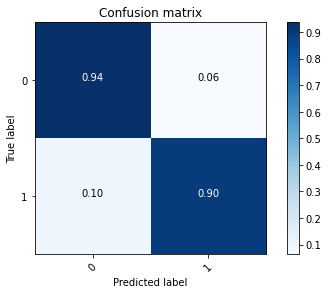

In [ ]:
evaluate_dset(test_xA, test_xB, test_tY, model_ii)

In [52]:
model_ii = NN(num_words_dict)
model_ii.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=init_lr), 
              metrics=['accuracy'])
model_ii.load_weights('/content/drive/MyDrive/PPI_Capsnet_20.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


8629/8629 [==============================] - 152s 18ms/step
Accuracy: 0.916445
Precision: 0.934913
Recall: 0.896924
Specificity: 0.899101
MCC: 0.833641
AUC: 0.960076
F1 Score: 0.915524
Distance to true labels: 0.131632 +- 0.233104
Normalized confusion matrix
[[0.94 0.06]
 [0.1  0.9 ]]


(array([[4001,  272],
        [ 449, 3907]]),
 0.9164445474562521,
 0.934912658530749,
 0.8969237832874196,
 0.8991011235955056,
 0.8336409436946178,
 0.9600758075403311,
 0.9155243116578793,
 0.13163203,
 0.23310444)

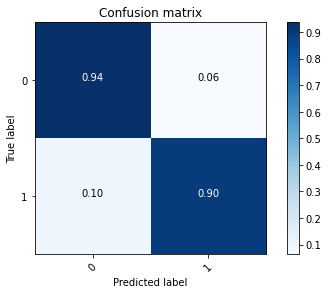

In [ ]:
evaluate_dset(test_xA, test_xB, test_tY, model_ii)

In [61]:
dset_ii_xA, dset_ii_xB, dset_ii_tY = generate_dset(valid_xA,
                                                       valid_xB,
                                                       valid_label,
                                                       decorrelate=do_order_decorrelation,
                                                       random_seed=0)
    
    # Now shuffle
shuffled_indices = np.random.RandomState(seed=0).permutation(dset_ii_tY.shape[0])
dset_ii_xA = dset_ii_xA[shuffled_indices]
dset_ii_xB = dset_ii_xB[shuffled_indices]
dset_ii_tY = dset_ii_tY[shuffled_indices]

split_index = int(0.75 * dset_ii_tY.shape[0])
# Up to the test split index, the test samples
test_xA = dset_ii_xA[split_index:]
test_xB = dset_ii_xB[split_index:]
test_tY = dset_ii_tY[split_index:]

# From the test split index to the end, the training samples
train_xA = dset_ii_xA[:split_index]
train_xB = dset_ii_xB[:split_index]
train_tY = dset_ii_tY[:split_index]

# Get an extra small validation set from the training set (90%). This will be used to stop the training
val_split = int(train_tY.shape[0] * 0.9)
val_xA = train_xA[val_split:]
val_xB = train_xB[val_split:]
val_tY = train_tY[val_split:]

train_xA = train_xA[:val_split]
train_xB = train_xB[:val_split]
train_tY = train_tY[:val_split]

8629/8629 [==============================] - 780s 90ms/step
Accuracy: 0.916445
Precision: 0.934913
Recall: 0.896924
Specificity: 0.899101
MCC: 0.833641
AUC: 0.960075
F1 Score: 0.915524
Kappa Score: 0.832940
Distance to true labels: 0.131632 +- 0.233104
Confusion matrix, without normalization
[[4001  272]
 [ 449 3907]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


(array([[4001,  272],
        [ 449, 3907]]),
 0.9164445474562521,
 0.934912658530749,
 0.8969237832874196,
 0.8991011235955056,
 0.8336409436946178,
 0.8329395610496337,
 0.9600753777375483,
 0.9155243116578793,
 0.13163203,
 0.23310445)

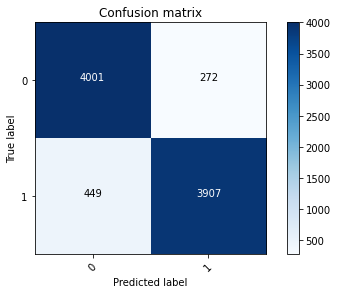

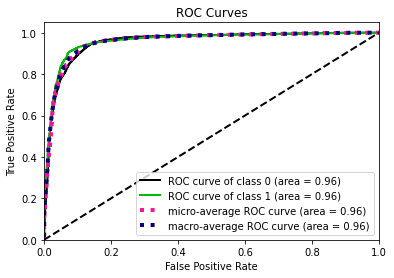

In [73]:
evaluate_dset(test_xA, test_xB, test_tY, model_ii)